In [1]:
import drjit as dr
import mitsuba as mi

from matplotlib import pyplot as plt

from mitsuba.scalar_rgb import Transform4f as T

import xml.etree.ElementTree as ET
import re
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import cv2

mi.set_variant('cuda_ad_rgb')


integrator = {
    'type': 'direct_reparam',
}




In [2]:
#print(dir(dr.cuda.ad.Quaternion4f))

#dr.cuda.ad.Quaternion4f(1,1,1,1)    ## xyzw scalar



In [3]:
"""
img = cv2.imread("render1.jpg")#img = cv2.imread(file_in_ref)/255
print(img.copy().shape[:2])
mask = np.zeros(img.copy().shape[:2], np.uint8)
cv2.imwrite("mask_render.png", mask)
"""

"""
img = cv2.imread("mask_render33.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #converting to grayscale
(thresh, blackAndWhiteImage) = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
img = img.astype(np.uint8)
cv2.imwrite("mask_render33_BW.png", blackAndWhiteImage)
#get all non zero values
#coord = cv2.findNonZero(img)
"""

'\nimg = cv2.imread("mask_render33.png")\nimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #converting to grayscale\n(thresh, blackAndWhiteImage) = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)\nimg = img.astype(np.uint8)\ncv2.imwrite("mask_render33_BW.png", blackAndWhiteImage)\n#get all non zero values\n#coord = cv2.findNonZero(img)\n'

In [4]:
#file_in_ref = "mask.png"
#file_in_ref = "mask_render.png"
file_in_ref = "mask_render33_BW.png"


#img_pil = Image.open(file_in)

#img = cv2.imread(file_in_ref)
#img = cv2.imread(file_in_ref, cv2.IMREAD_UNCHANGED)
img = cv2.imread(file_in_ref)/255
print("max pix val",np.max(img))

#width, height = img_pil.size
#img_bit = "test1.bmp"
#print(img_ref)
#image_res = [width,height]


#print(image_res)


max pix val 1.0


original dim (288, 162)
resized shape (162, 288, 3) max pix val 1.0


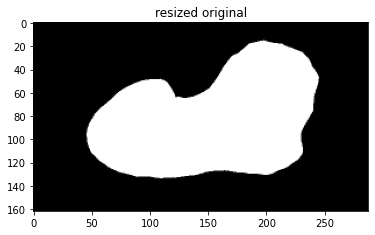

TensorXf(shape=(162, 288, 3)) max pix val 1.0


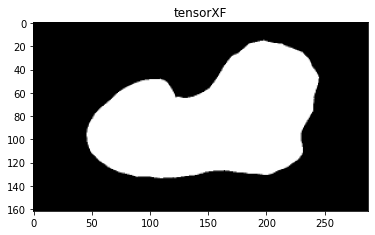

TensorXf(shape=(162, 288, 3))


In [5]:
scale_percent = 50 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width,height)
print('original dim',dim)


# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print("resized shape",resized.shape,"max pix val",np.max(resized))
plt.imshow(resized)
plt.title('resized original')
plt.show()



#img_ref = mi.TensorXf(img)
img_ref = mi.TensorXf(resized)
#img_ref = mi.TensorXf(resized/255)
print(img_ref,"max pix val",np.max(img_ref))
plt.imshow(img_ref)
plt.title('tensorXF')
plt.show()

print(img_ref)

In [6]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    'sensor': {
        'type': 'perspective',
        'to_world': T.look_at(
            origin=(0, -1.5, 0),
            target=(0, 0, 0),
            up=(0, 0, 1)
        ),
        'fov': 120,
        'film': {
            'type': 'hdrfilm',
            'width': width,
            'height': height,
            'rfilter': {'type': 'gaussian'},
            'sample_border': True
        },
    },

    'liver': {
        'type': 'obj',
        #'filename': 'originalMesh.obj',
        #'filename': 'semisynthetic_liver_v1p0/Meshes/objectdef_inv.obj',
        'filename': 'semisynthetic_liver_v1p0/Meshes/bendingOutwards_inv.obj',
        'to_world': T.scale(0.005),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'mesh_attribute',
                'name': 'face_color'
            }},
    },
    'light': {
        'type': 'obj',
        'filename': '/home/tfrancois/Desktop/mitsuba-tutorials-master/scenes/meshes/sphere.obj',
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [2e2, 2e2, 2e2]}
        },
        'to_world': T.translate([0, -5, 0]).scale(0.25)
    }
})



In [7]:
"""
face_colors = []
for i in range(scene.shapes()[1].face_count()):
    face_colors.append([0, 0.5, 0])
    

face_colors = [item for sublist in face_colors for item in sublist]
#print(face_colors)
print(len(face_colors))

scene.shapes()[1].add_attribute('face_color',3, face_colors)

"""

"\nface_colors = []\nfor i in range(scene.shapes()[1].face_count()):\n    face_colors.append([0, 0.5, 0])\n    \n\nface_colors = [item for sublist in face_colors for item in sublist]\n#print(face_colors)\nprint(len(face_colors))\n\nscene.shapes()[1].add_attribute('face_color',3, face_colors)\n\n"

In [8]:
#img_ran = mi.render(scene, seed=0, spp=256)

#mi.util.convert_to_bitmap(img_ran)

In [9]:
tree = ET.parse('contours.xml')
root = tree.getroot()

vert_idx =[]

cut =[]
l =0

for new in root.findall(".//modelPoints"):
    for x in new.findall(".//vertices"):
        vert_idx.append(x.text)

for jo in root.findall(".//contour"):
    for lo in jo.findall(".//contourType"):
        l += 1
        if lo.text == "Ridge":
            cut.append(l)


In [10]:
vert_org = [[None for x in range(0)] for y in range(len(vert_idx))]

for i in range(len(vert_idx)):
    vert = re.findall('[0-9]+', vert_idx[i])
    for j in range(len(vert)):
        vert_org[i].append(int(vert[j]))

In [11]:
x = scene.shapes()[1].face_indices(2000)
print("Total num of faces Mitsuba",scene.shapes()[1].face_count(),"mitsuba at face 4000",scene.shapes()[1].face_indices(4000),scene.shapes()[1].face_indices(4000)[0])

Total num of faces Mitsuba 4000 mitsuba at face 4000 [[0, 0, 0]] [0]


In [12]:
u = [item for subset in vert_org for item in subset]
print("Model vertex indices",u)
yu = np.asarray(u)

Model vertex indices [156, 210, 260, 303, 302, 421, 464, 697, 567, 694, 722, 870, 967, 867, 767, 809, 674, 831, 994, 2106, 2284, 2479, 2612, 2672, 3022]


In [13]:
print('will take some time to append colors vals wait a few min please')

all_faces = [[None for x in range(scene.shapes()[1].face_count())] for y in range(0)]

for yelp in range(scene.shapes()[1].face_count()):
    x= scene.shapes()[1].face_indices(yelp)
    all_faces.append(x)
    if yelp == scene.shapes()[1].face_count() -1:   ## mitsuba bug ! doesnt stop after end of total faces
        #print("hello")
        break
        #file_in = "mask.png"
        #file_in = file_in_ref

#img_pil = Image.open(file_in)

#img = cv2.imread(file_in)
#img = cv2.imread(file_in, cv2.IMREAD_UNCHANGED)

#width, height = img_pil.size
#img_bit = "test1.bmp"
#print(img_ref)
#image_res = [width,height]


#print(image_res)

will take some time to append colors vals wait a few min please


In [14]:
total_faces = 0
face_idx = []
face_colors = []

for face in range(len(all_faces)):
    verts = all_faces[face]
    #print("face",face)

    for vert in yu:
        if (vert in verts):
            #face_colors.append([0, 0.5, 0])
            face_colors.append([0.5, 0.5, 0.5])
            face_idx.append(face)
            total_faces+=1
            break
    if len(face_colors) == face:
        face_colors.append([0.5, 0.5, 0.5])

In [15]:
face_colors = [item for sublist in face_colors for item in sublist]

In [16]:
if len(face_colors) == scene.shapes()[1].face_count()*3:
    print("Face x RGB matches ")

Face x RGB matches 


In [17]:
print("total faces painted", total_faces)
print("face painted list ",face_idx)
print("check face-model point corresp",scene.shapes()[1].face_indices(face_idx[1]),scene.shapes()[1].face_indices(face_idx[100]))
scene.shapes()[1].add_attribute('face_color', 3, face_colors)

total faces painted 105
face painted list  [237, 238, 239, 257, 258, 259, 312, 313, 314, 387, 388, 389, 390, 393, 394, 457, 458, 459, 460, 461, 494, 495, 496, 497, 498, 499, 627, 628, 629, 678, 679, 680, 681, 707, 708, 709, 759, 760, 761, 864, 865, 866, 867, 868, 1035, 1036, 1037, 1072, 1073, 1074, 1075, 1076, 1077, 1103, 1104, 1105, 1118, 1119, 1120, 1166, 1167, 1168, 1221, 1222, 1223, 1224, 1262, 1263, 1264, 1276, 1277, 1278, 1321, 1322, 1323, 1324, 1325, 1326, 1470, 1471, 1472, 1505, 1506, 1507, 1515, 1516, 1545, 1546, 1547, 1561, 1562, 1563, 2602, 2603, 2611, 2612, 2613, 2812, 2813, 2814, 3529, 3530, 3641, 3642, 3643]
check face-model point corresp [[156, 155, 157]] [[830, 1909, 831]]


In [18]:
img_scene_trans = mi.render(scene, seed=0, spp=256)
mi.util.convert_to_bitmap(img_scene_trans)
print(img_scene_trans)

TensorXf(shape=(162, 288, 3))


In [19]:
params = mi.traverse(scene)
initial_vertex_positions = dr.unravel(mi.Point3f, params['liver.vertex_positions'])

In [20]:
LR = 0.005
opt = mi.ad.Adam(lr=LR)

opt['angle_x'] = mi.Float(0.0)
opt['angle_y'] = mi.Float(0.0)
opt['angle_z'] = mi.Float(0.0)  

opt['trans'] = mi.Point3f(0.0, 0.0,0.0)  ## x,z,y

In [21]:
def apply_transformation(params, opt):
    #opt['trans'] = dr.clamp(opt['trans'], -0.8, 0.5)  
    #opt['angle_x'] = dr.clamp(opt['angle_x'], -0.5, 0.6)
    #opt['angle_y'] = dr.clamp(opt['angle_y'], -0.5, 0.5)
    #opt['angle_z'] = dr.clamp(opt['angle_z'], -0.5, 0.9)
    
    #dr.cuda.ad.Quaternion4f

    ## Just rotate
    #trafo = mi.Transform4f.rotate([1, 0, 0], opt['angle_x'] * 100.0).rotate([0, 1, 0], opt['angle_y'] * 100.0).rotate([0, 0, 1], opt['angle_z'] * 100.0)
    
    ## Just translate
    #trafo = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, opt['trans'].z])
    
    ## full transform
    
    trafo = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, opt['trans'].z])\
    .rotate([1, 0, 0], opt['angle_x'] * 100.0).rotate([0, 1, 0], opt['angle_y'] * 100.0).rotate([0, 0, 1], opt['angle_z'] * 100.0)
       
    params['liver.vertex_positions'] = dr.ravel(trafo @ initial_vertex_positions)
    params.update()

In [22]:
apply_transformation(params, opt)

img_init = mi.render(scene, seed=0, spp=256)

mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [288, 162],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 137 KiB of image data ]
]

In [23]:
iteration_count = 1000
spp = 16

loss_hist = []

angle_hist =[]
trans_hist = []

params_hist= []

for it in range(iteration_count):
    
    
    
    # Apply the mesh transformation
    apply_transformation(params, opt)
    
    params_hist.append(dr.unravel(mi.Point3f, params['liver.vertex_positions']))
    
    # Perform a differentiable rendering
    img = mi.render(scene, params, seed=it, spp=spp)
    #img_new=mi.util.convert_to_bitmap(img)
    #img_new.write(f"render{it}.jpg")

    # Evaluate the objective function
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    loss_hist.append(loss)
    
    #print(params['liver.vertex_positions'])
    
    #angle_hist.append([opt['angle_x'][0],opt['angle_y'][0],opt['angle_z'][0]])
                                                              
    #trans_hist.append([opt['trans'].x[0],opt['trans'].y[0],opt['trans'].z[0]])
    
    
    ## Just rotate
    #print(f"Iteration {it:02d}: error={loss[0]:6f}, angle=[{opt['angle_x'][0]:.4f},{opt['angle_y'][0]:.4f},{opt['angle_z'][0]:.4f}]", end='\r')
    
    ## Just translate
    ## print(f"Iteration {it:02d}: error={loss[0]:6f}, trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f},{opt['trans'].z[0]:.4f}]", end='\r')
    
    
    ## full transform
    print(f"Iteration {it:02d}: error={loss[0]:6f}, angle=[{opt['angle_x'][0]:.4f},{opt['angle_y'][0]:.4f},{opt['angle_z'][0]:.4f}],\
    trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f},{opt['trans'].z[0]:.4f}]", end='\r')

KeyboardInterrupt: 

KeyboardInterrupt: 

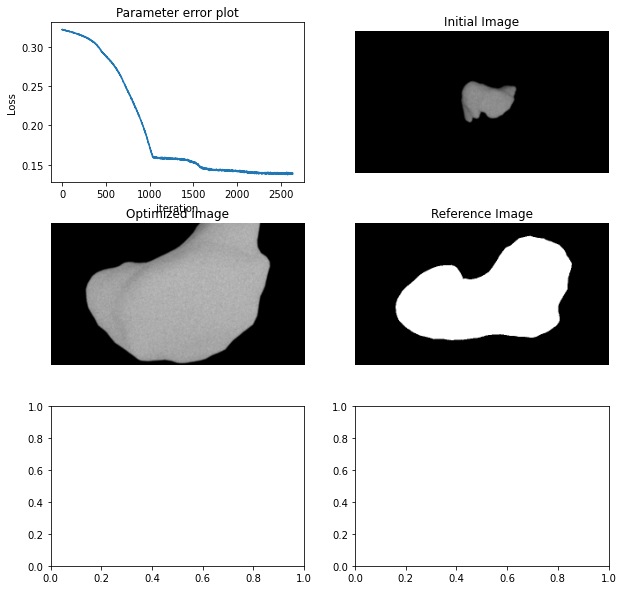

In [24]:

## test for deformation  ## bendingOutwards_inv.obj mesh   

## compared with originalmesh.obj mask

## LR 0.05

# no limits
    
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title("Parameter error plot")

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');


min_loss = dr.min(loss_hist)
min_loss_idx = loss_hist.index(min_loss) #+ 1
print(min_loss_idx)
params['liver.vertex_positions'] = dr.ravel(params_hist[min_loss_idx])
params.update()


axs[2,1].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[2,1].axis('off')
axs[2,1].set_title('least loss render')

axs[2,0].axis('off')

245


(0.0, 1.0, 0.0, 1.0)

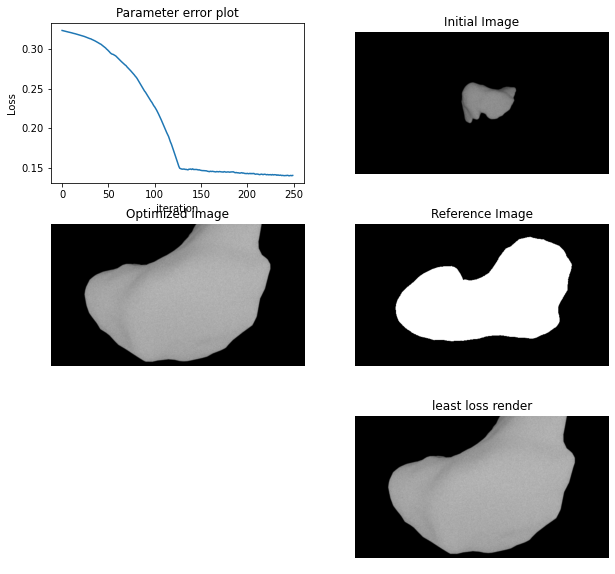

In [31]:

## test for deformation  ## bendingOutwards_inv.obj mesh   

## compared with originalmesh.obj mask

## LR 0.05

# no limits
    
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title("Parameter error plot")

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');


min_loss = dr.min(loss_hist)
min_loss_idx = loss_hist.index(min_loss) #+ 1
print(min_loss_idx)
params['liver.vertex_positions'] = dr.ravel(params_hist[min_loss_idx])
params.update()


axs[2,1].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[2,1].axis('off')
axs[2,1].set_title('least loss render')

axs[2,0].axis('off')

866


(0.0, 1.0, 0.0, 1.0)

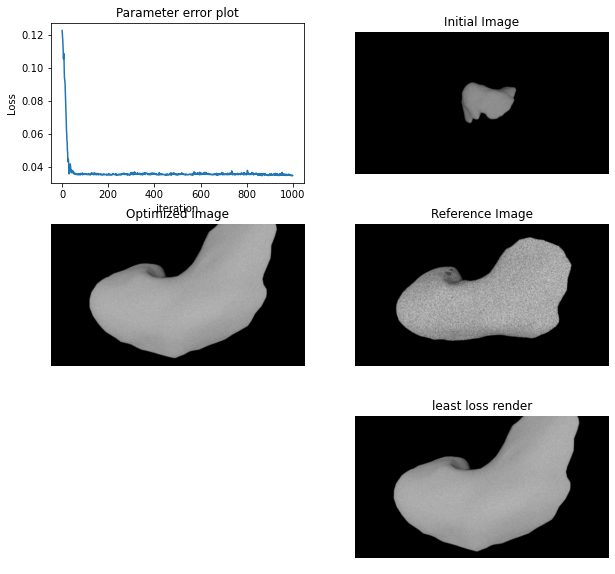

In [24]:

## test for deformation  ## bendingOutwards_inv.obj mesh   

## compared with originalmesh.obj render

## LR 0.05

# no limits
    
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title("Parameter error plot")

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');


min_loss = dr.min(loss_hist)
min_loss_idx = loss_hist.index(min_loss) #+ 1
print(min_loss_idx)
params['liver.vertex_positions'] = dr.ravel(params_hist[min_loss_idx])
params.update()


axs[2,1].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[2,1].axis('off')
axs[2,1].set_title('least loss render')

axs[2,0].axis('off')

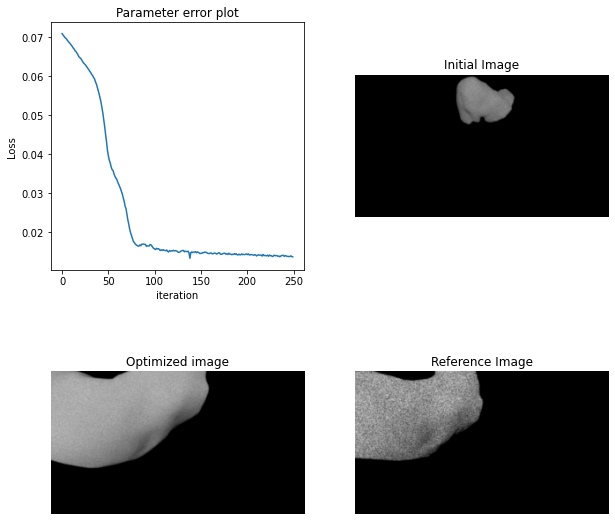

In [30]:
## render 138 render   ## LR 0.005

# no limits
    
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title("Parameter error plot")

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

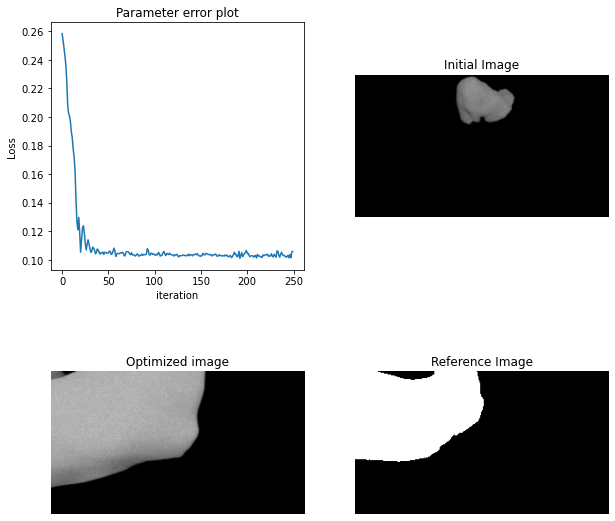

In [33]:
## render 138 BW   ## LR 0.05

# no limits
    
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title("Parameter error plot")

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

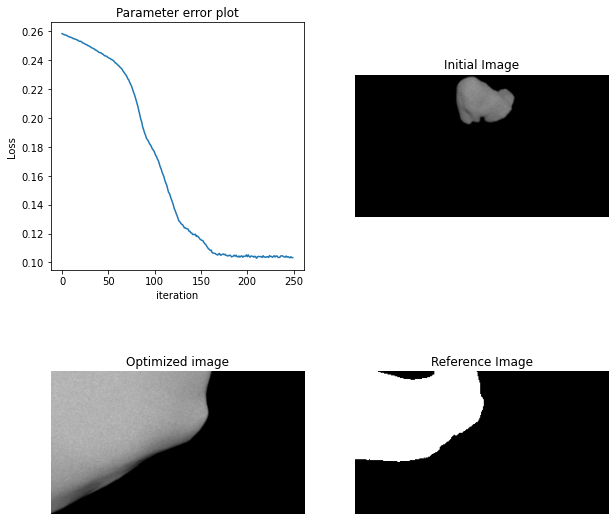

In [24]:
## render 138 BW   ## LR 0.0025

# tran -0.8, 0.5
# x -0.5, 0.6
# y -0.5, 0.5
# z -0.5, 0.9
    
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title("Parameter error plot")

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

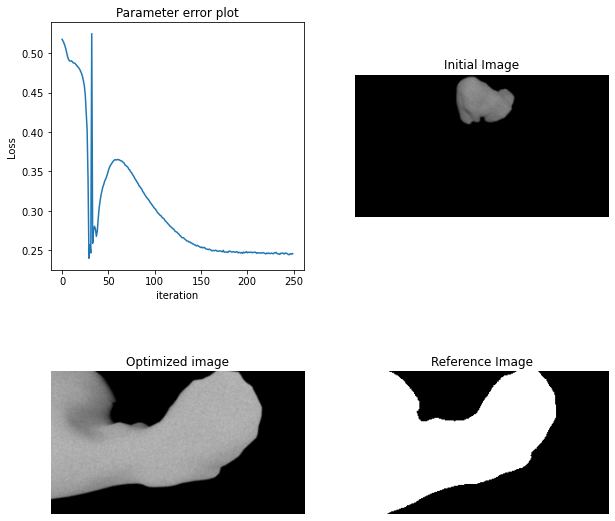

In [26]:
## render 15 BW   ## LR 0.0025

# no limits
    
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title("Parameter error plot")

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

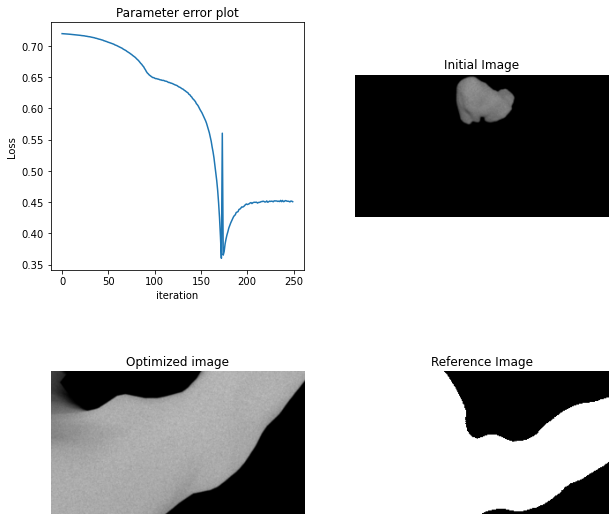

In [59]:
## render 13 BW   ## LR 0.0025

#trans -0.8, 0.5
#angle_x -0.5, 0.6
#angle_y -0.5, 0.5
#angle_z -0.5, 0.9
    
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title("Parameter error plot")

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

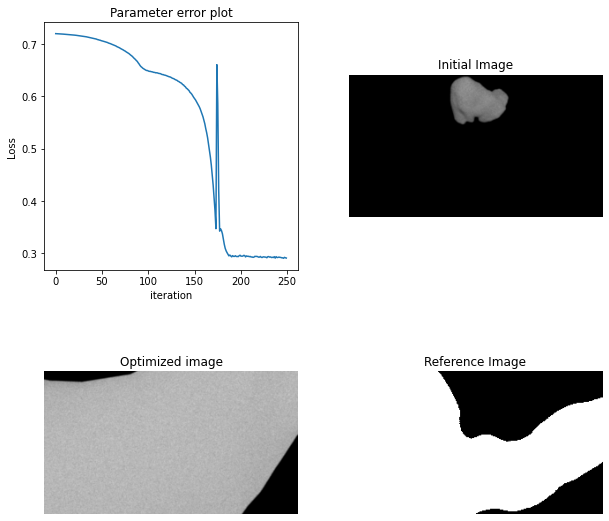

In [53]:

## render 13 BW   ## LR 0.0025

#trans -0.8, 0.5
#angle_x -0.5, 0.5
#angle_y -0.5, 0.5
#angle_z -0.5, 0.9
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');Automatic 3D/2D Deformable Registration in Minimally Invasive Liver Resection using a Mesh Recovery Network
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title("Parameter error plot")

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

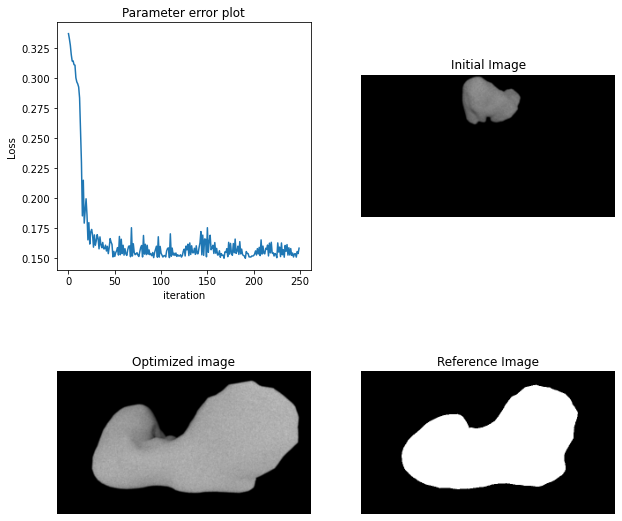

In [24]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

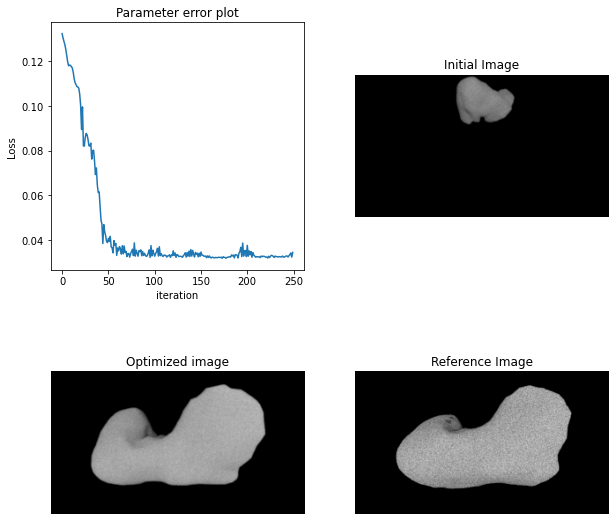

In [24]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=256)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

#axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].imshow(img_ref)
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');